# Single model pFBA predictions

In [49]:
import reframed
import pandas as pd
import numpy as np

import seaborn as sns

import os
import json
import functions.general_functions as general_func

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [51]:
all_mags_paper = general_func.read_allmags_data()
all_mags_paper.head(2)

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.1,Compost_Digestate,Xylan,99.37,0.32,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora amygdalina_A,5147597.0,48.0,197896.0,4902.0,CH14-bin.1,54.707294
CH14-bin.2,Compost_Digestate,Xylan,99.37,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Robinsoniella,Robinsoniella peoriensis,5647052.0,70.0,172899.0,4618.0,CH14-bin.2,18.831114


#### Load models

In [52]:
with open("output/GEMs/GEMs_adapt.json") as json_file:
    GEMs_adapt = json.load(json_file)
    
gems_adapt_dict = {"no_constr":"output/GEMs/GEMs_no_constraints/",
                  "constr0_1":"output/GEMs/GEMs_soft_constraints_score_0.1/"}


In [53]:
with open("output/relevant_MAGs_99.txt") as text_file:
    relevant_MAGs = text_file.read().split("\n")

relevant_MAGs = [string.replace("\t","") for string in relevant_MAGs]


In [54]:
GEMs_dict = {}
for MAG in relevant_MAGs:
    print(MAG)
    directory = gems_adapt_dict[GEMs_adapt[MAG]]
    GEMs_dict[MAG]= reframed.load_cbmodel(directory+MAG+".xml")


CH14-bin.1
CH14-bin.2
CH14-bin.4
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH3-bin.2
CH3-bin.1
CH3-bin.0
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14


### Define environment

**From SynCon2 to SynCon1**

"SynCon2 had the same composition, but it lacked ascorbic acid, and it had two additional trace elements (selenium and wolfram)"

Add
- Ascorbate: ascb__L

Remove
- Selenite (inorganic selenium): slnt
- (wolfram: not in BiGG database)

In [55]:
syncon2 = pd.read_csv("input/syncon2media_combined.csv",header=None)

syncon1 = list(syncon2[0].values)
syncon1.remove("slnt")
syncon1.append("ascb__L")

syncon2 = syncon2[0].values

In [56]:
substrate_composition = {"Avicel":["cellb","cell3","cell4","cell5"],
                         "PASC":["cellb","cell3","cell4","cell5"],
                         "Xylan":["xylb","xyl3","xylan4","xylan8"]}

In [57]:
syncon2_environments = {}
for substrate_name,met_mols in substrate_composition.items():
    syncon2_environments[substrate_name]= reframed.Environment.from_compounds(syncon2)
    for met in met_mols:
        syncon2_environments[substrate_name]["R_EX_"+met+"_e"]=(-10,0)

### FBA growth predictions

In [58]:
community_groups = all_mags_paper.groupby(by= ["Source","Substrate"]).groups

In [59]:
FBA_growth = {}
for community, MAGs in community_groups.items(): 
    FBA_growth[community]={}
    for MAG in MAGs:
        
        if MAG not in relevant_MAGs:
            continue
            
        print(MAG)
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        sol = reframed.FBA(model)
        
        if sol is None:
            FBA_growth[community][MAG]=None
        else:
            FBA_growth[community][MAG]=sol

CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/

CH14-bin.1
CH14-bin.2
CH14-bin.4
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH3-bin.2
CH3-bin.1
CH3-bin.0


In [60]:
mags_growth = pd.Series({GEM:sol.fobj for GEM_sol_dict in FBA_growth.values() for GEM,sol in GEM_sol_dict.items()})

# Add the source and substrate to this data
growth_community_df = pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],mags_growth],axis=1)

# Change from float to False or positive
growth_community_df.dropna(inplace=True)
growth_community_df["Grows"] = growth_community_df[0].map(lambda x:x>1e-6)

# Drop the growth float column
growth_community_df.drop(0,axis=1,inplace=True)

# Group by source and substrate
growth_community_grouped_df = growth_community_df.groupby(["Source","Substrate"]).value_counts()

# Change grows index to column
growth_community_grouped_df = growth_community_grouped_df.reset_index(level="Grows")

# Make different columns for grows and does not grow
growth_community_grouped_df = pd.concat([growth_community_grouped_df[growth_community_grouped_df["Grows"]].drop("Grows",axis=1),growth_community_grouped_df[~growth_community_grouped_df["Grows"]].drop("Grows",axis=1)],axis=1)

# Name columns
growth_community_grouped_df.columns = ["# growing","# not growing"]
growth_community_grouped_df.fillna(0,inplace=True)
growth_community_grouped_df["# growing"] = growth_community_grouped_df["# growing"].map(int)
growth_community_grouped_df

# growing  # not growing
Source            Substrate                          
Compost_Digestate Avicel             1              9
                  PASC               2             13
                  Xylan              1              2
Cow_Manure        Avicel             3             10
                  PASC               4             11
Marshland         PASC               1              6
                  Xylan              1              2
Cow_Manure        Xylan              0              6

In [61]:
growth_community_grouped_df

# growing  # not growing
Source            Substrate                          
Compost_Digestate Avicel             1              9
                  PASC               2             13
                  Xylan              1              2
Cow_Manure        Avicel             3             10
                  PASC               4             11
Marshland         PASC               1              6
                  Xylan              1              2
Cow_Manure        Xylan              0              6

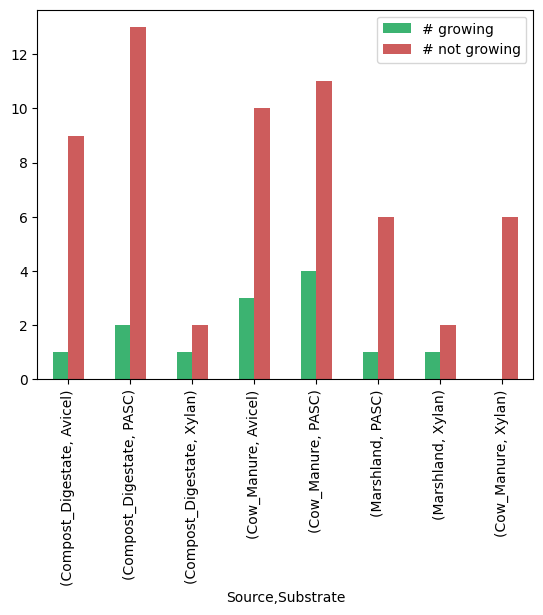

In [62]:
import matplotlib.pyplot as plt



growth_community_grouped_df.plot(kind="bar",color=['mediumseagreen','indianred'])
plt.savefig("grows_count.png",bbox_inches='tight')

In [63]:
all_mags_paper[all_mags_paper.index.isin(growth_community_df[growth_community_df.Grows].index)]

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.1,Compost_Digestate,Xylan,99.37,0.32,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora amygdalina_A,5147597.0,48.0,197896.0,4902.0,CH14-bin.1,54.707294
CH3-bin.1,Marshland,Xylan,99.31,4.52,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium_S,NaN,6360127.0,130.0,86322.0,5672.0,CH3-bin.1,21.418886
CH15-bin.22,Compost_Digestate,PASC,99.35,0.65,Bacteria,Desulfobacterota,Desulfuromonadia,Desulfuromonadales,Syntrophotaleaceae,Syntrophotalea,Syntrophotalea acetylenica,2967869.0,82.0,59021.0,2733.0,CH15-bin.22,5.516420
CH15-bin.16,Compost_Digestate,PASC,99.37,2.22,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,NaN,5604339.0,23.0,423081.0,5254.0,CH15-bin.16,4.253342
CH7-bin.16,Cow_Manure,PASC,99.11,0.00,Bacteria,Desulfobacterota,Desulfovibrionia,Desulfovibrionales,Desulfovibrionaceae,Humidesulfovibrio,NaN,3127892.0,27.0,407700.0,2927.0,CH7-bin.16,8.489853
CH7-bin.2,Cow_Manure,PASC,97.30,0.68,Bacteria,Verrucomicrobiota,Verrucomicrobiae,Opitutales,Verruco-01,Verruco-01,Verruco-01 sp016928295,2529650.0,33.0,128050.0,2023.0,CH7-bin.2,4.041395
CH7-bin.1,Cow_Manure,PASC,98.91,3.84,Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Trichococcus,N/A,2925786.0,51.0,109473.0,2727.0,CH7-bin.1,2.610298
CH7-bin.20,Cow_Manure,PASC,97.72,1.61,Bacteria,Firmicutes,Clostridia,Christensenellales,CAG-74,NaN,NaN,3414990.0,98.0,74193.0,3154.0,CH7-bin.20,1.731405
CH1-bin.8,Marshland,PASC,97.11,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lacrimispora,Lacrimispora celerecrescens_B,5085002.0,53.0,230023.0,4663.0,CH1-bin.8,3.871541


**Production**

In [64]:
FBA_production = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]

for community, MAGs in community_groups.items(): 
    FBA_production[community]={}
    
    for MAG in MAGs:
        if MAG not in relevant_MAGs:
            continue
        print(MAG)
            
        model = GEMs_dict[MAG]
        syncon2_environments[community[1]].apply(model,inplace=True,exclusive=True)
        
        FBA_production[community][MAG] = {}
        
        for met in interesting_compounds:
            if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
                FBA_production[community][MAG][met]=None
                continue
            
            sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

            if sol is None:
                FBA_production[community][MAG][met]=None
            else:
                FBA_production[community][MAG][met]=sol.fobj

CH13-bin.12
CH13-bin.11


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_b12_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_slnt_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_ribflv_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_pydxn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core

CH13-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_btn_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cellb_e
  warn(f'Exchange reaction not in model: {r_id}')


CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH14-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_so4_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xyl3_e
  warn(f'Exchange reaction not in model: {r_id}')


CH14-bin.2
CH14-bin.4


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylb_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan8_e
  warn(f'Exchange reaction not in model: {r_id}')
/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_xylan4_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_cys__L_e
  warn(f'Exchange reaction not in model: {r_id}')


CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1


/Users/idunmariaburgos/opt/anaconda3/envs/MAGs_RecAndAn2/lib/python3.9/site-packages/reframed/core/environment.py:75: UserWarning: Exchange reaction not in model: R_EX_fe2_e
  warn(f'Exchange reaction not in model: {r_id}')


CH1-bin.10
CH3-bin.2
CH3-bin.1
CH3-bin.0


In [65]:
pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()

,etoh,lac__L,ac,ppa,but,2mpa,isobuta,ibt,pta,hxa,isocap
CH13-bin.12,NaN,10.000000,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CH13-bin.11,NaN,20.000000,20.000000,11.764706,-0.0,NaN,NaN,NaN,NaN,-0.000000,NaN
CH13-bin.4,NaN,NaN,-0.000000,-0.000000,-0.0,NaN,-0.0,NaN,-0.000000,-0.000000,NaN
CH13-bin.14,NaN,70.000000,70.000000,-0.000000,NaN,NaN,NaN,NaN,70.000000,70.000000,105.250
CH13-bin.25,NaN,NaN,37.777778,48.571429,59.0,NaN,NaN,NaN,NaN,-0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
CH1-bin.1,NaN,-0.000000,-0.000000,-0.000000,NaN,NaN,NaN,-0.0,-0.000000,-0.000000,NaN
CH1-bin.10,NaN,-0.000000,-0.000000,NaN,-0.0,NaN,NaN,NaN,-0.000000,-0.000000,NaN
CH3-bin.2,182.694656,50.000000,50.000000,NaN,50.0,NaN,122.8,50.0,NaN,-0.000000,NaN
CH3-bin.1,NaN,47.893639,36.666667,41.803279,NaN,NaN,NaN,NaN,45.348837,41.417910,NaN


In [66]:
# Add the source and substrate to this data
prod_sour_sub_df= pd.concat([all_mags_paper.loc[:,["Source","Substrate"]],pd.DataFrame({GEM:sol for sour_sub,GEM_sol_dict in FBA_production.items() for GEM,sol in GEM_sol_dict.items()}).transpose()],axis=1)

prod_sour_sub_df.fillna(0,inplace=True)

In [67]:
# Change from floats to binary
prod_sour_sub_df_bools =  prod_sour_sub_df.iloc[:,:2]

prod_sour_sub_df_bools = pd.concat([prod_sour_sub_df_bools,prod_sour_sub_df.iloc[:,2:].map(lambda x:x>1e-6)],axis=1)

prod_sour_sub_df_bools

,Source,Substrate,etoh,lac__L,ac,ppa,but,2mpa,isobuta,ibt,pta,hxa,isocap
CH14-bin.1,Compost_Digestate,Xylan,False,False,True,True,True,True,False,False,False,False,True
CH14-bin.2,Compost_Digestate,Xylan,False,False,True,True,False,False,False,False,False,False,False
CH14-bin.4,Compost_Digestate,Xylan,False,False,False,False,False,False,False,False,False,False,False
CH9-bin.0,Cow_Manure,Xylan,False,False,True,False,False,False,False,True,False,False,False
CH9-bin.6,Cow_Manure,Xylan,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH8-bin.11,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH13-bin.16,Compost_Digestate,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH8-bin.27,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False
CH8-bin.20,Cow_Manure,Avicel,False,False,False,False,False,False,False,False,False,False,False


In [68]:
# Group by source and substrate
prod_sour_sub_grouped_df = prod_sour_sub_df_bools.groupby(["etoh"]).value_counts()

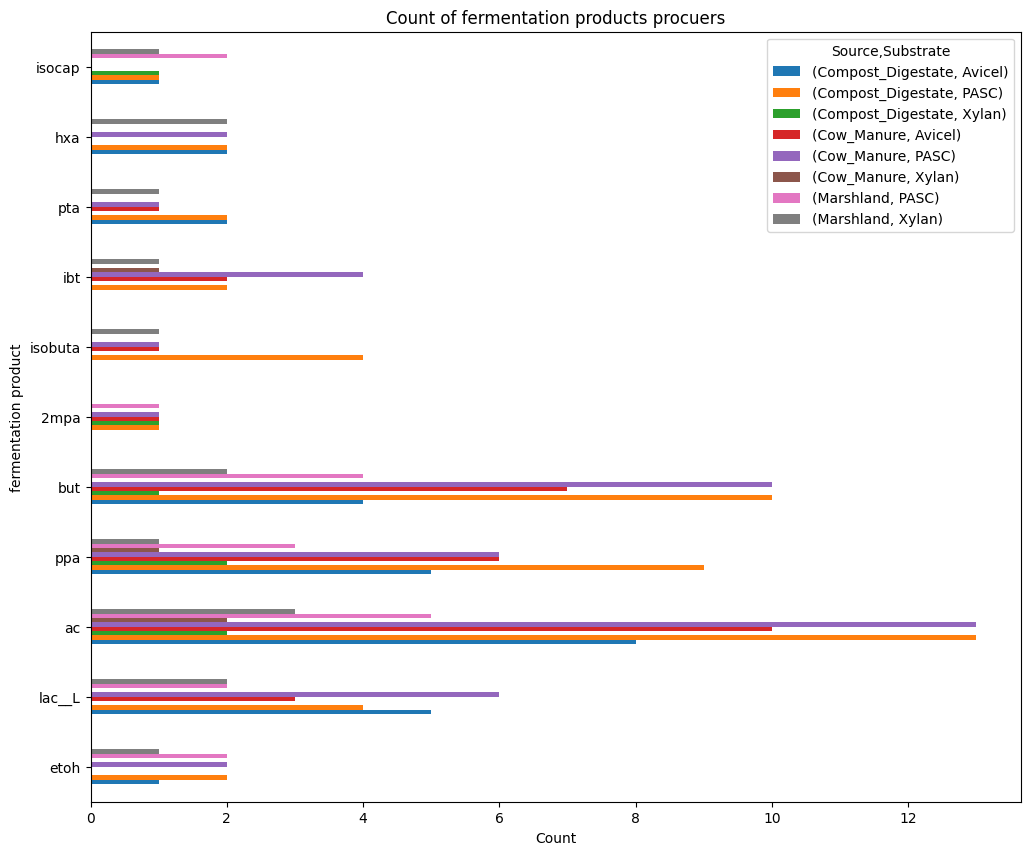

In [69]:
prod_sour_sub_df_bools.groupby(["Source","Substrate"]).sum().transpose().plot(kind="barh",figsize=(12,10))
plt.xlabel("Count")
plt.ylabel("fermentation product")
plt.title("Count of fermentation products procuers")
plt.show()

#### Production in complete media

In [70]:
FBA_production_complete = {}

interesting_compounds = ["etoh","lac__L","ac","ppa","but","2mpa","isobuta","ibt","pta","hxa","isocap"]


for MAG,model in GEMs_dict.items(): 
    print(MAG)
    FBA_production_complete[MAG]={}
        
    model = GEMs_dict[MAG]
    reframed.Environment.complete(model=model,inplace=True)
    
    for met in interesting_compounds:
        if "R_EX_"+met+"_e" not in model.get_exchange_reactions():
            FBA_production_complete[MAG][met]=None
            continue

        sol = reframed.FBA(model,objective={"R_EX_"+met+"_e":1})

        if sol is None:
            FBA_production_complete[MAG][met]=None
        else:
            FBA_production_complete[MAG][met]=sol.fobj

CH14-bin.1
CH14-bin.2
CH14-bin.4
CH9-bin.0
CH9-bin.6
CH9-bin.5
CH9-bin.1
CH9-bin.2
CH9-bin.4
CH3-bin.2
CH3-bin.1
CH3-bin.0
CH15-bin.0
CH15-bin.23
CH15-bin.1
CH15-bin.7
CH15-bin.8
CH15-bin.22
CH15-bin.6
CH15-bin.17
CH15-bin.16
CH15-bin.13
CH15-bin.12
CH15-bin.5
CH15-bin.10
CH15-bin.15
CH15-bin.2
CH7-bin.23
CH7-bin.16
CH7-bin.11
CH7-bin.13
CH7-bin.2
CH7-bin.8
CH7-bin.18
CH7-bin.1
CH7-bin.17
CH7-bin.4
CH7-bin.12
CH7-bin.20
CH7-bin.9
CH7-bin.6
CH7-bin.15
CH1-bin.6
CH1-bin.9
CH1-bin.3
CH1-bin.4
CH1-bin.8
CH1-bin.1
CH1-bin.10
CH13-bin.12
CH13-bin.11
CH13-bin.4
CH13-bin.14
CH13-bin.25
CH13-bin.17
CH13-bin.0
CH13-bin.1
CH13-bin.13
CH13-bin.2
CH8-bin.22
CH8-bin.17
CH8-bin.7
CH8-bin.2
CH8-bin.6
CH8-bin.25
CH8-bin.5
CH8-bin.9
CH8-bin.16
CH8-bin.21
CH8-bin.8
CH8-bin.29
CH8-bin.14


In [71]:
prod_complete = pd.DataFrame(FBA_production_complete)
prod_complete

,CH14-bin.1,CH14-bin.2,CH14-bin.4,CH9-bin.0,CH9-bin.6,CH9-bin.5,CH9-bin.1,CH9-bin.2,CH9-bin.4,CH3-bin.2,...,CH8-bin.2,CH8-bin.6,CH8-bin.25,CH8-bin.5,CH8-bin.9,CH8-bin.16,CH8-bin.21,CH8-bin.8,CH8-bin.29,CH8-bin.14
etoh,NaN,NaN,995.562943,NaN,NaN,NaN,NaN,1686.275582,NaN,3038.740741,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lac__L,NaN,NaN,896.388638,NaN,NaN,10.000000,NaN,NaN,NaN,1495.000000,...,NaN,NaN,852.476415,NaN,NaN,NaN,NaN,311.979063,NaN,NaN
ac,1365.397878,1559.166667,860.689655,695.0,501.578947,514.643517,1260.0,697.006803,599.166667,1505.000000,...,681.093750,819.251329,1158.430657,452.421875,162.142857,559.195402,510.104167,267.681159,758.541800,1010.00000
ppa,1395.666667,1549.166667,NaN,NaN,110.000000,508.333333,1270.0,657.500000,NaN,NaN,...,763.228354,1418.275862,NaN,-0.000000,103.465262,1360.920513,NaN,-0.000000,963.164953,968.28125
but,1396.924435,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,10.000000,1505.000000,...,740.000000,265.810811,NaN,546.000000,NaN,653.655418,30.024393,NaN,342.076720,1020.00000
2mpa,1795.326087,NaN,NaN,NaN,NaN,545.000000,NaN,NaN,10.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702.116281,NaN
isobuta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1567.583333,...,NaN,952.886179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ibt,NaN,NaN,NaN,695.0,NaN,NaN,NaN,NaN,NaN,1438.076923,...,NaN,NaN,-0.000000,NaN,263.091927,NaN,520.700000,186.843854,NaN,NaN
pta,NaN,NaN,494.538043,-0.0,NaN,NaN,NaN,-0.000000,-0.000000,NaN,...,760.000000,-0.000000,-0.000000,NaN,NaN,NaN,NaN,NaN,-0.000000,NaN
hxa,NaN,-0.000000,10.000000,NaN,NaN,-0.000000,NaN,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.000000,-0.000000,-0.000000,10.000000,-0.000000,-0.000000,-0.000000,-0.000000,10.00000
